## Two Moon Classification with stochastic depth

* We will take the two moon dataset as a dummy dataset that's easy to visualize, and just qualitatively see how the uncertainty boundaries differ compared to dropout.
    * IF the results look good, we'll also try to implement other methods such as Laplace Approximation for visualization

In [1]:
import numpy as np
import torch
from torch import nn
from torchvision.ops import StochasticDepth

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from tqdm import tqdm

from torch import Tensor
from typing import List, Tuple


### Two Moon dataset

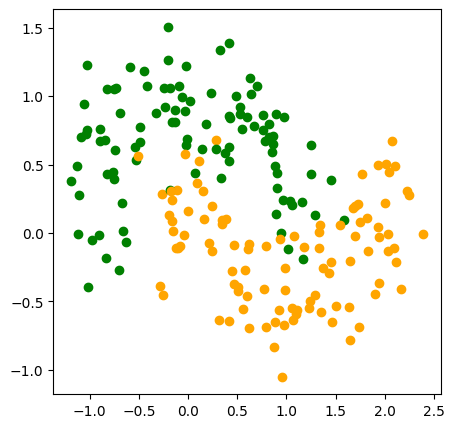

In [2]:
def split_dataset(X, Y, train_ratio=0.8):
    n = len(X)
    n_train = int(n * train_ratio)
    indices = torch.randperm(n)
    train_indices, test_indices = indices[:n_train], indices[n_train:]
    X_train, Y_train = X[train_indices], Y[train_indices]
    X_test, Y_test = X[test_indices], Y[test_indices]

    return X_train, Y_train, X_test, Y_test


def plot_two_moons(X, Y):
    plt.figure(figsize=(5, 5))
    for i in range(len(X)):
        plt.scatter(X[i, 0], X[i, 1], c="orange" if Y[i] == 1 else "green")

    # plt.axis("off")


X, Y = make_moons(n_samples=200, shuffle=True, noise=0.25, random_state=1)
X, Y = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)
# X = nn.functional.normalize(X, dim=0)

# X_train, Y_train, X_test, Y_test = split_dataset(X, Y, 0.8)

plot_two_moons(X, Y)

### Bayesian Network Wrapper Class

In [3]:
class Bayesian_net(nn.Module):
    """
    Bayesian network class has two internal states, dropout_state and stochastic_depth_state.
    They overwrite the default behaviour of forward pass to enable switching between bayesian and deterministic modes.
    Toggling the states is done by calling set_bayes_mode method.
    """

    def __init__(self) -> None:
        super().__init__()
        self.dropout_state: bool = False
        self.stochastic_depth_state: bool = False

    def _toggle_dropout(self) -> None:
        # override the default behaviour of dropout layers
        if self.dropout_state:
            for m in self.modules():
                if m.__class__.__name__.startswith("Dropout"):
                    m.train()

    def _toggle_stochastic_depth(self) -> None:
        # override the default behaviour of stochastic depth layers
        if self.stochastic_depth_state:
            for m in self.modules():
                if m.__class__.__name__.startswith("StochasticDepth"):
                    m.train()

    def _set_dropout(self, state: bool) -> None:
        self.dropout_state = state

    def _set_stochastic_depth(self, state: bool) -> None:
        self.stochastic_depth_state = state

    def set_bayes_mode(self, state: bool, mode: str) -> None:
        if mode == "dropout":
            self._set_dropout(state)
        elif mode == "sd":
            self._set_stochastic_depth(state)
        else:
            print(f"Mode {mode} is not supported.")

    def forward(self, x: Tensor) -> Tensor:
        self._toggle_stochastic_depth()
        self._toggle_dropout()

        return self._forward_impl(x)

    def _forward_impl(self, x: Tensor) -> Tensor:
        raise NotImplementedError

### A simple residual network

In [4]:
class Residual_sd_block(nn.Module):
    """Implements a simple x + lin(x) block"""

    def __init__(self, features: int, p: float = 0.5) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(features, features), nn.BatchNorm1d(features), nn.ReLU()
        )
        self.p = p
        self.sd = StochasticDepth(p, mode="row")

    def forward(self, x: Tensor) -> Tensor:
        out = self.block(x)
        out = self.sd(out)
        # apply skip connection
        out = x + out
        return out

In [5]:
class Sd_network(Bayesian_net):
    def __init__(self, inp: int, oup: int, N: int, d_feat: int, p=0.5):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Linear(inp, d_feat),
            nn.BatchNorm1d(d_feat),
            nn.ReLU(),
            *[Residual_sd_block(d_feat, p=p) for _ in range(N)],
            nn.Linear(d_feat, oup),
            nn.Sigmoid()
        )

    def _forward_impl(self, x: Tensor) -> Tensor:
        return self.blocks(x)

### A simple dropout network

In [142]:
class Residual_dropout_block(nn.Module):
    """Implements a simple dropout(lin(x)) block"""

    def __init__(self, features: int, p: float = 0.5) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(features, features), nn.BatchNorm1d(features)
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout1d(p=p)

    def forward(self, x: Tensor) -> Tensor:
        out = self.block(x)
        out = self.dropout(out)
        # apply skip connection
        out = x + out
        out = self.relu(out)
        return out

In [97]:
class Dropout_network(Bayesian_net):
    def __init__(self, inp: int, oup: int, N: int, d_feat: int, p=0.5):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Linear(inp, d_feat),
            nn.BatchNorm1d(d_feat),
            nn.ReLU(),
            *[Residual_dropout_block(d_feat, p=p) for _ in range(N)],
            nn.Linear(d_feat, oup),
            nn.Sigmoid()
        )

    def _forward_impl(self, x: Tensor) -> Tensor:
        return self.blocks(x)

In [185]:
def Bayes_forward(net: Bayesian_net, x: Tensor, bayes_mode: str, T: int):
    net.eval()
    net.set_bayes_mode(True, mode=bayes_mode)
    with torch.no_grad():
        y_logits_samples = net(x.repeat(T, 1))
        y_logits = y_logits_samples.mean(dim=0)

    return y_logits

### Train networks

100%|██████████| 500/500 [00:01<00:00, 487.81it/s]


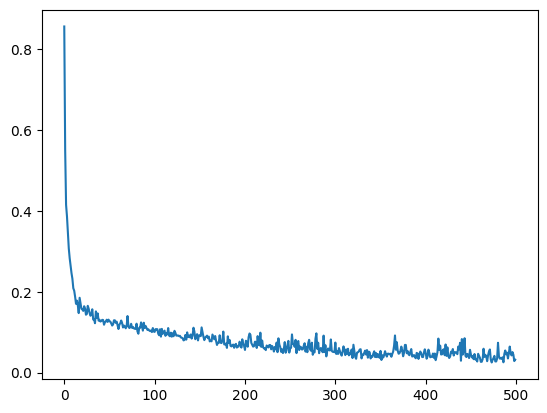

In [200]:
net = Dropout_network(inp=2, oup=1, N=2, d_feat=50, p=0.1)
# net = Sd_network(inp=2, oup=1, N=20, d_feat=5, p=0.5)
net.train()
optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
criterion = nn.BCELoss()

history = []

for epoch in tqdm(range(500)):
    optimizer.zero_grad()
    y_logits = net(X)
    loss = criterion(y_logits.squeeze(1), Y)
    loss.backward()
    optimizer.step()

    history.append(loss.item())

plt.plot(history)

tensor(0.9850)


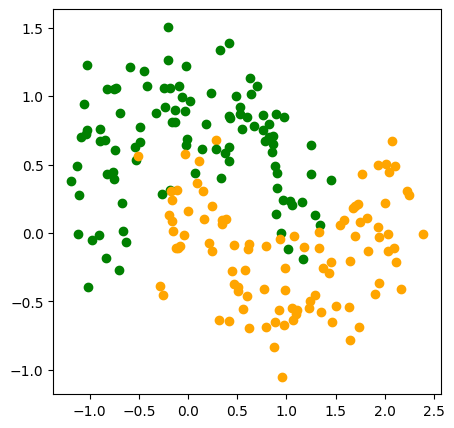

In [199]:
net.eval()
with torch.no_grad():
    net.set_bayes_mode(False, 'sd')
    y_pred = net(X) > 0.5

plot_two_moons(X, y_pred)

print((y_pred.squeeze() == Y).sum()/len(Y))

### Qualitative view of confidence scores

In [196]:
def plot_confidence(net: Bayesian_net, bayes_mode, T, precision=100):
    net.eval()
    XX, YY = np.meshgrid(np.linspace(-3, 3, precision), np.linspace(-3, 3, precision))
    with torch.no_grad():
        inp = torch.FloatTensor(np.stack((XX.ravel(), YY.ravel())).T)
        py = net(inp)
        # py = torch.empty((len(inp), 1), dtype=torch.float)
        # for i, x in enumerate(tqdm(inp)):
        #     py[i] = Bayes_forward(net, x.unsqueeze(0), bayes_mode=bayes_mode, T=T)
        conf = torch.where(py > 0.5, py, 1 - py)  ## THIS LINE COMPUTES THE CONFIDENCE
        conf = py
        ZZ = conf.reshape(XX.shape)

        CS = plt.contourf(XX, YY, ZZ, cmap="PiYG", vmin=0.5, vmax=1.2)
        plt.colorbar(ticks=np.linspace(0.5, 1, 6))
        plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="autumn", edgecolor="k")
        plt.title("Confidence plot")

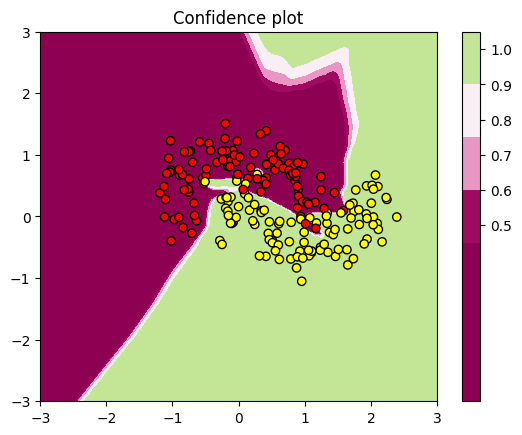

In [201]:
plot_confidence(net, "dropout", T=30, precision=100)